## N-BEATS (Darts) ? 1/7/30 kunlik forecast


In [1]:
print('hi')

hi


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

In [6]:
# Ma'lumotlarni yuklash
p = Path('../datasets/usd_rates_ready.csv')
df = pd.read_csv(p)

df.columns = [c.lower() for c in df.columns]
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

# Target = rate, date ishlatilmaydi, qolgan 21 ta ustun feature sifatida
feature_cols = [c for c in df.columns if c not in ['date', 'rate']]

# Outlierlarni IQR bilan yumshatish (faqat targetda)
def clip_iqr(s, k=1.5):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - k * iqr, q3 + k * iqr
    return s.clip(lower, upper)

df['rate'] = clip_iqr(df['rate'])

# Vaqt bo'yicha train/val/test (70/15/15)
n = len(df)
train_end = int(n * 0.70)
val_end = int(n * 0.85)
train_df = df.iloc[:train_end]
val_df = df.iloc[train_end:val_end]
test_df = df.iloc[val_end:]

# Bashorat ufqlari
horizons = [1, 7, 30]

try:
    from darts import TimeSeries
    from darts.models import NBEATSModel
    from darts.dataprocessing.transformers import Scaler
except ImportError:
    raise SystemExit("Darts o'rnatilmagan: pip install darts[u]")

series = TimeSeries.from_dataframe(df, time_col='date', value_cols='rate')
covariates = TimeSeries.from_dataframe(df, time_col='date', value_cols=feature_cols)

scaler_y = Scaler()
scaler_x = Scaler()

series_s = scaler_y.fit_transform(series)
cov_s = scaler_x.fit_transform(covariates)

train, rest = series_s.split_before(0.70)
val, test = rest.split_before(0.50)

cov_train, cov_rest = cov_s.split_before(0.70)
cov_val, cov_test = cov_rest.split_before(0.50)

model = NBEATSModel(
    input_chunk_length=25,
    output_chunk_length=10,
    n_epochs=30,
    random_state=0,
    pl_trainer_kwargs={
    "accelerator": "gpu",
    "devices": "auto",  # yoki 1, 2
}
)
model.fit(train, past_covariates=cov_train, val_series=val, val_past_covariates=cov_val)

val_pred = model.predict(n=len(val), series=train, past_covariates=cov_train.concatenate(cov_val))
test_pred = model.predict(n=len(test), series=train.concatenate(val), past_covariates=cov_train.concatenate(cov_val).concatenate(cov_test))

mae_val = mean_absolute_error(val.values(), val_pred.values())
rmse_val = root_mean_squared_error(val.values(), val_pred.values())
r2_score_val = r2_score(val.values(), val_pred.values())


mae_test = mean_absolute_error(test.values(), test_pred.values())
rmse_test = root_mean_squared_error(test.values(), test_pred.values())
r2_score_test = root_mean_squared_error(test.values(), test_pred.values())

print(f"Vali MAE: {mae_val:.2f},  RMSE: {rmse_val:.4f},  R2 Score: {r2_score_val:.4f}")
print(f"Test MAE: {mae_test:.2f}, RMSE: {rmse_test:.4f}, R2 Score: {r2_score_test:.4f}")


c:\Ai\AI_Rate_Prediction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
The StatsForecast module could not be imported. To enable support for the AutoARIMA, AutoETS and Croston models, please consider installing it.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  

Epoch 29: 100%|██████████| 56/56 [00:03<00:00, 14.86it/s, train_loss=0.000123, val_loss=0.000423]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 56/56 [00:03<00:00, 14.85it/s, train_loss=0.000123, val_loss=0.000423]


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]
Vali MAE: 0.02,  RMSE: 0.0220,  R2 Score: 0.5825
Test MAE: 0.03, RMSE: 0.0313, R2 Score: 0.0313


In [7]:
# 1/7/30 forecast: covariates oxirgi qiymati bilan uzaytiriladi
horizon_forecasts = {}
for h in horizons:
    future_dates = pd.date_range(df['date'].max() + pd.Timedelta(days=1), periods=h, freq='D')
    last_cov = cov_s.values()[-1]
    future_cov_vals = np.repeat(last_cov[np.newaxis, :], h, axis=0)
    future_cov = TimeSeries.from_times_and_values(future_dates, future_cov_vals)
    full_cov = cov_s.concatenate(future_cov)
    fc = model.predict(n=h, series=series_s, past_covariates=full_cov)
    fc_inv = scaler_y.inverse_transform(fc)
    horizon_forecasts[f'h_{h}'] = fc_inv.to_dataframe()

horizon_forecasts['h_30'].head(10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 41.21it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 42.55it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.58it/s]


,rate
date,
2025-12-10,11899.516779
2025-12-11,12006.277188
2025-12-12,11951.747645
2025-12-13,11795.395379
2025-12-14,12089.227639
2025-12-15,12048.912779
2025-12-16,11887.866321
2025-12-17,11889.511382
2025-12-18,12065.639094


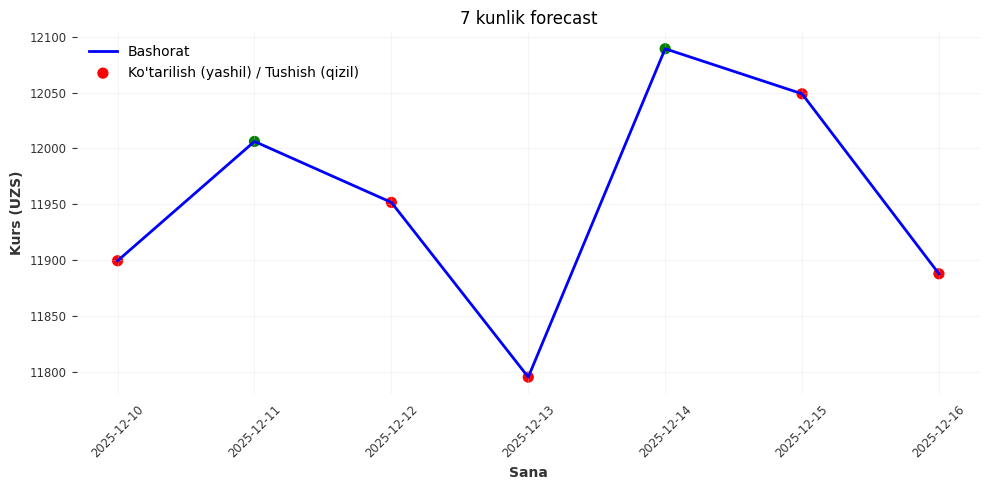

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_forecast_darts(h_key='h_7', title='Forecast'):
    fc_df = horizon_forecasts[h_key].copy().reset_index()

    # Yagona qiymat ustunini avtomatik aniqlash
    value_col = [c for c in fc_df.columns if c not in ('time', 'date')][0]

    # ustunlarni standartlashtiramiz
    fc_df.rename(columns={'time': 'date', value_col: 'forecast'}, inplace=True)

    # Ko'tarilish / tushish aniqlash
    fc_df['delta'] = fc_df['forecast'].diff()
    inc_mask = fc_df['delta'] >= 0
    colors = np.where(inc_mask, 'green', 'red')

    plt.figure(figsize=(10, 5))

    # Forecast line
    plt.plot(fc_df['date'], fc_df['forecast'], label='Bashorat', color='blue', linewidth=2)

    # Up/down points
    plt.scatter(
        fc_df['date'], fc_df['forecast'],
        c=colors, s=50,
        label="Ko'tarilish (yashil) / Tushish (qizil)"
    )

    plt.title(title)
    plt.xlabel("Sana")
    plt.ylabel("Kurs (UZS)")
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_forecast_darts('h_7', '7 kunlik forecast')
